In [1]:
from cycada_utils import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'On {device}')

Figure directory exists.
On cuda:0


In [2]:
class CyDataset(Dataset):
    def __init__(self):

        self.D = []
        self.L = []
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_labeled.pkl', "rb") as fp:
            for station in pkl.load(fp):
#                 if station['PM25'] <600:
                self.D.append(tuple((station['Image'][:,:,:3], station['PM25'])))
                
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:
            for station in pkl.load(fp):
                for datapoint in station:
                    luck_img = datapoint['Image'][:,:,:3]
                    if luck_img.shape == (224, 224,3):  
                        self.L.append(tuple((luck_img, datapoint['PM'])))
                        
        self.L = random.choices(self.L, k= len(self.D))
        
    def __len__(self): return (len(self.D))
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.ToTensor()])

        d_img = self.D[idx][0]
        d_img = transform(d_img)        
        l_img = self.L[idx][0]
        l_img = transform(l_img)
        
        sample = {
              'D img': d_img,
              'D pm' : torch.tensor(self.D[idx][1]),
              'L img': l_img,
              'L pm' : torch.tensor(self.L[idx][1])
        }
        return sample

In [3]:
tr = CyDataset()
train, val = train_test_split(tr, test_size=0.2, random_state=42)
train_dataloader = DataLoader(
    train,
    batch_size=5, # 1
    shuffle=True)

val_dataloader = DataLoader(
    val,
    batch_size=5, # 1
    shuffle=False)

In [4]:
norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
generator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_gens.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/best_discs.pt')
feature_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/feature_level/best_dft.pt')
main_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cicada/feature_level/best_main.pt')
#G's and D's will be pre loaded and set grad to false

G_ST = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_ST.load_state_dict(generator_checkpoint['G_ST'])

G_TS = ResnetGenerator(3, 3, 64, norm_layer=norm_layer, use_dropout=False, n_blocks=2)
G_TS.load_state_dict(generator_checkpoint['G_TS'])

D_T = NLayerDiscriminator(3)
D_T.load_state_dict(discriminator_checkpoint['D_T'])

D_S = NLayerDiscriminator(3)
D_S.load_state_dict(discriminator_checkpoint['D_S'])

D_ft = FeatureDiscriminator()
D_ft.load_state_dict(feature_checkpoint['D_ft'])

f_s = Multi_City_CNN()
f_s.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cicada/pixel_level/saved_models/dlm4.pt'))

f_t = LeNet(3)
f_t.load_state_dict(main_checkpoint['f_t'])


G_ST.to(device)
G_TS.to(device)
D_S.to(device)
D_T.to(device)
D_ft.to(device)
f_s.to(device)
f_t.to(device)

ganloss = GANLoss().to(device)                         
cycleloss = torch.nn.L1Loss().to(device)               
ftloss = torch.nn.modules.CrossEntropyLoss().to(device)          
mseloss = torch.nn.MSELoss().to(device)      

optimizer_G = torch.optim.Adam(itertools.chain(G_ST.parameters(), G_TS.parameters()), lr=2e-4, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(itertools.chain(D_S.parameters(), D_T.parameters()), lr=1e-5, betas=(0.5, 0.999))
optimizer_f_s = torch.optim.Adam(f_s.parameters(), lr=1e-4, betas=(0.5, 0.999))  

optimizer_f_t = torch.optim.Adam(f_t.parameters(), lr=1e-5, betas=(0.5, 0.999))    #different learning rate??
optimizer_D_ft = torch.optim.Adam(D_ft.parameters(), lr=1e-5, betas=(0.5, 0.999))


print('locked and loaded')

locked and loaded


# Phase 3

In [6]:
phase3df = pd.read_csv('/datacommons/carlsonlab/srs108/cicada/feature_level/history.csv')
phase3df.head()

,epoch,Dft_loss,mainloss,batch
0,1,0.639776,1334.332886,2500
1,1,0.528463,4319.421875,5000
2,2,0.816741,9151.623047,2500
3,2,0.546401,5209.645508,5000
4,3,0.823236,145491.421875,2500


In [21]:
def loss(loss, epochs, save = True, type_of_loss = '', fig_name=''):
#     epoch = range(epochs)
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(epochs, loss, color='r', linewidth=0.5)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title(str(type_of_loss))
    
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')

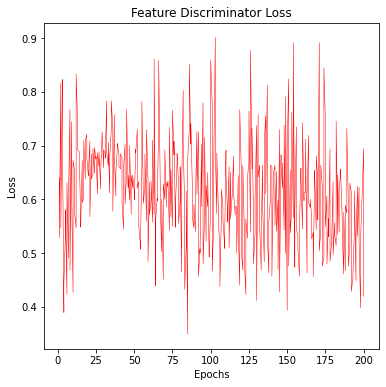

In [22]:
loss(phase3df['Dft_loss'], phase3df['epoch'], save=False, type_of_loss = 'Feature Discriminator Loss')

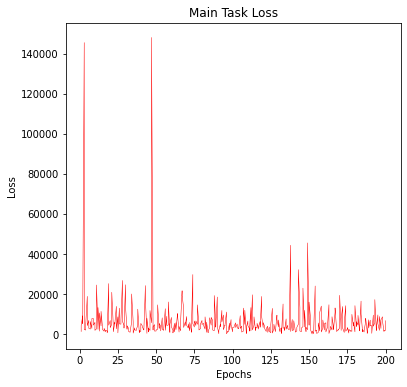

In [23]:
loss(phase3df['mainloss'], phase3df['epoch'], save=False, type_of_loss = 'Main Task Loss')

# Phase 2

In [24]:
def gen_dis_loss(genloss, disloss, iters, save = True, fig_name=''):
#     epoch = range(epochs)
    fig, ax = plt.subplots(1,1, figsize = (6,6))   
    ax.plot(iters, genloss, color='b', linewidth=0.5, label='Generator')
    ax.plot(iters, disloss, color='r', linewidth=0.5, label='Discriminator')
    ax.set_xlabel('Iters')
    ax.set_ylabel('Loss')
    ax.set_title('Generator and Discriminator Loss')
    ax.legend()
    plt.show()
    if save==True:
        fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.png', transparent=False, facecolor='white', bbox_inches='tight')

In [31]:
phase2df

,epoch,G_loss,D_loss,cycloss,semloss,batch
0,1,0.102275,1.381273e-03,0.100789,2209.831787,2500
1,1,0.095762,1.986242e-03,0.094692,886.387573,5000
2,2,0.102230,6.855246e-05,0.101814,2031.746094,2500
3,2,0.124208,1.400868e-04,0.123920,2476.270508,5000
4,3,0.081322,2.894741e-05,0.081205,1374.511353,2500
...,...,...,...,...,...,...
95,48,0.024201,0.000000e+00,0.024201,2250.255371,5000
96,49,0.041750,0.000000e+00,0.041750,1682.338623,2500
97,49,0.032725,2.645176e-11,0.032724,1049.863037,5000
98,50,0.021688,0.000000e+00,0.021688,912.137817,2500


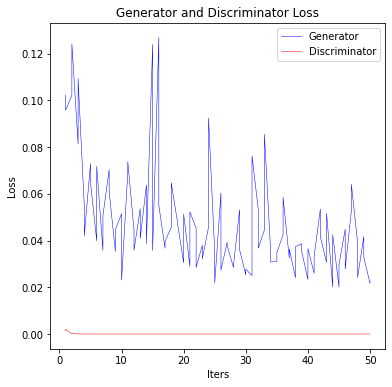

In [26]:
phase2df = pd.read_csv('/datacommons/carlsonlab/srs108/cicada/pixel_level/history.csv')
gen_dis_loss(phase2df['G_loss'], phase2df['D_loss'], phase2df['epoch'], save = False, fig_name='')

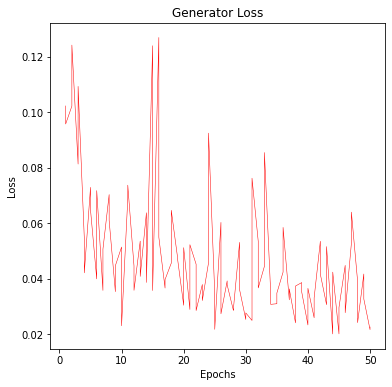

In [32]:
loss(phase2df['G_loss'], phase2df['epoch'], save=False, type_of_loss = 'Generator Loss')

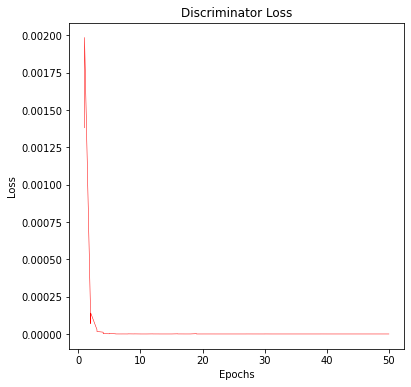

In [33]:
loss(phase2df['D_loss'], phase2df['epoch'], save=False, type_of_loss = 'Discriminator Loss')

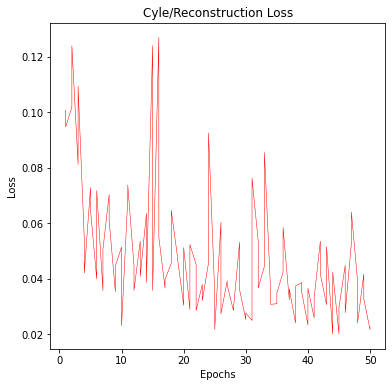

In [28]:
loss(phase2df['cycloss'], phase2df['epoch'], save=False, type_of_loss = 'Cyle/Reconstruction Loss')

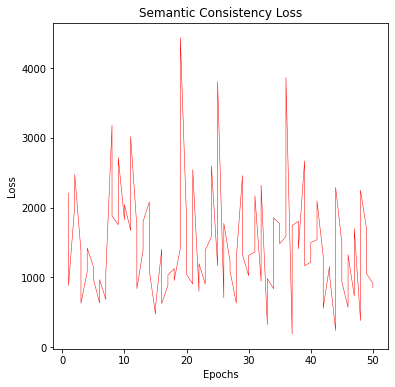

In [30]:
loss(phase2df['semloss'], phase2df['epoch'], save=False, type_of_loss = 'Semantic Consistency Loss')